In [1]:
%load_ext lab_black

# ERCOT HDD

In this notebook we will look at the return period of the heating demand days over the part of Texas that is in ERCOT, weighting by population from various years or not at all

In [2]:
from labellines import labelLines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
from scipy.stats import genextreme as gev
import xarray as xr

from codebase.calc import optimizer
from codebase.fig import figname

In [3]:
hdd = xr.open_dataset("../data/processed/era5/tx/hdd_ercot.nc")

In this data, the

* `hdd_pop_weighted` is the heating degree days aggregated over space by weighting each pixel in accordance with the population density for a fixed year. We look at 2000, 2005, 2010, 2015, and 2020 -- the default will be 2020.
* `hdd_unweighted` is the heating degree days aggregated over space by giving each pixel equal weight.

Both use heating degree days estimated from the ERA5 data at 0.25 degrees

## IDF Curves

We're going to construct IDF Curves for several data sets.
First, we will need to compute the HDD at various lags.
Our data is hourly

In [4]:
DURATIONS = [
    1,
    2,
    3,
    4,
    6,
    8,
    10,
    12,
    16,
    20,
    24,
    28,
    32,
    36,
    40,
    44,
    48,
    56,
    64,
    72,
    80,
    88,
    96,
]
hdd_roll = xr.concat(
    [
        hdd.rolling(time=duration).mean().assign_coords({"duration": duration})
        for duration in DURATIONS
    ],
    dim="duration",
)

Next we will construct annual maximum time series

In [5]:
# group together December YYYY and Jan YYYY+1
times = pd.to_datetime(hdd_roll["time"].values)
year_eff = times.year + np.int_(times.month > 7)
hdd_roll["year_eff"] = xr.DataArray(
    year_eff, coords={"time": hdd_roll["time"]}, dims="time"
)
hdd_annual = hdd_roll.groupby("year_eff").max(dim="time")

In [9]:
RETURN_PERIODS = [2, 5, 10, 25, 50, 100]

In [11]:
plot_info = [
    [
        hdd_annual["hdd_pop_weighted"].sel(pop_year=2020),
        "Average Heating Demand Over ERCOT, Pixels Weighted by 2020 Population",
        figname("ERCOT_HDD_weighted2020.pdf"),
    ],
    [
        hdd_annual["hdd_unweighted"],
        "Average Heating Demand Over ERCOT, All Pixels Weighted Equally",
        figname("ERCOT_HDD_unweighted.pdf"),
    ],
]

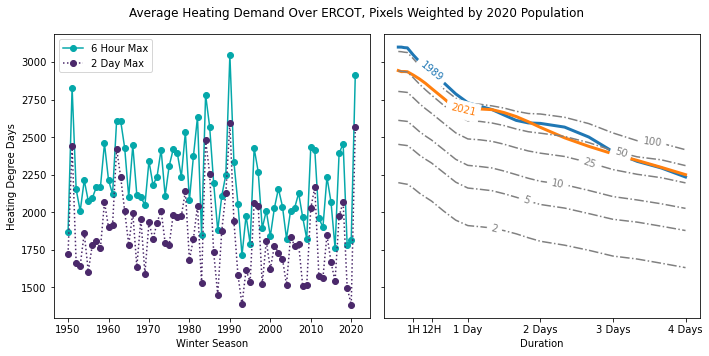

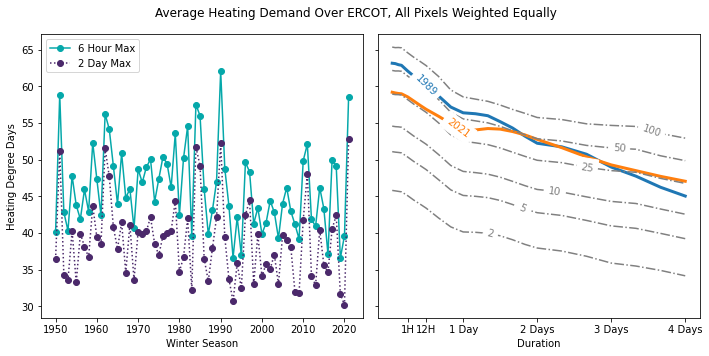

In [22]:
for obs, title, fname in plot_info:

    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(10, 5), sharey=True, sharex=False
    )

    # Plot Time Series
    ax = axes[0]
    obs.sel(duration=6).plot(ax=ax, label="6 Hour Max", color="#05A8AA", marker="o")
    obs.sel(duration=48).plot(
        ax=ax, label="2 Day Max", color="#4B296B", linestyle=":", marker="o"
    )
    ax.set_ylabel("Heating Degree Days")
    ax.legend(loc="upper left")
    ax.set_title("")
    ax.set_xlabel("Winter Season")

    # Plot IDF CURVE
    ax = axes[1]
    obs.sel(year_eff=1990).plot(
        ax=ax, label="1989", linewidth=3
    )  # Dec 1989 is coded as 1990 here
    obs.sel(year_eff=2021).plot(ax=ax, label="2021", linewidth=3)
    for rp in RETURN_PERIODS:
        ax.plot(
            DURATIONS,
            [
                gev(
                    *gev.fit(
                        obs.sel(duration=duration),
                        0,
                        loc=1000,
                        scale=100,
                        optimizer=optimizer,
                    )
                ).isf(1 / rp)
                for duration in DURATIONS
            ],
            label=rp,
            color="gray",
            linestyle="-.",
        )
    labelLines(ax.get_lines(), zorder=2.5)
    ax.set_xlabel("Duration")
    ax.set_xticks([6, 12, 24, 48, 72, 96])
    ax.set_xticklabels(["1H", "12H", "1 Day", "2 Days", "3 Days", "4 Days"])
    ax.set_title("")
    ax.set_ylabel("")

    fig.subplots_adjust(top=0.925)
    fig.suptitle(title)

    fig.canvas.draw()
    fig.tight_layout()
    plt.savefig(fname)
    plt.show()

Done!